## Libraries

In [53]:
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from gplearn.fitness import make_fitness

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
import pickle

In [54]:
import cufflinks as cf
cf.go_offline()

In [55]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

In [56]:
%run ..\..\Data\triangulars.ipynb
%run ..\Function.ipynb

## Functions

### Gplearn functions

In [57]:
# custom metric
def _mape(y, y_pred, w):
    diffs = np.abs(np.divide((np.maximum(0.001, y) - np.maximum(0.001, y_pred)),np.maximum(0.001, y)))
    
    return 100. * np.average(diffs, weights=w)

mape = make_fitness(_mape, greater_is_better=False)

In [58]:
cos_7 = make_function(function=CustomSC.cos_7, name='cos_7', arity=1)

sin_7 = make_function(function=CustomSC.sin_7, name='sin_7', arity=1)

cos_365 = make_function(function=CustomSC.cos_365, name='cos_365', arity=1)

sin_365 = make_function(function=CustomSC.sin_365, name='sin_365', arity=1)

abscos_14 = make_function(function=CustomSC.abscos_14, name='abscos_14', arity=1)

abssin_14 = make_function(function=CustomSC.abssin_14, name='abssin_14', arity=1)

In [59]:
def one(x1):
    return np.ones(len(x1))

one = make_function(function = one, 
                    name = 'one', 
                    arity = 1)

In [60]:
def time(x1):
    return np.arange(1, len(x1)+1)

time = make_function(function = time,
                    name = 'time',
                    arity = 1)

### model functions

In [61]:
def predict1(X, y, model):
    # scale data
    X_train1, X_test1, y_train, y_test = train_test_split(X, consumo, test_size = 365, shuffle = False)
    scaler1 = MaxAbsScaler(); scaler1.fit(y_train)
    y_train = scaler1.transform(y_train).reshape(-1) 
    y_test = scaler1.transform(y_test).reshape(-1)
    
    scaler = MaxAbsScaler(); scaler.fit(X_train1)
    X_train = scaler.transform(X_train1)
    X_test = scaler.transform(X_test1)
    # predict with loaded model (gplearn)
    y_predtr = model.predict(X_train)
    y_predte = model.predict(X_test)
    # join forecasting and train prediction
    y_pred = np.hstack([y_predtr, y_predte])
    # create dataframe
    y_pred = scaler1.inverse_transform(y_pred.reshape(-1, 1))
    plotting = pd.DataFrame(y_pred, index = consumo.index, columns = ["predict"])
    plotting["real"] = consumo.to_numpy()
    return plotting

In [62]:
def mape_comp(y):
    return np.mean(np.abs((y.real - y.predict)/y.real))*100

## Create X

In [63]:
path_consumo = Path().resolve().parents[1] / "Data" / "Data1.xlsx"
consumo = pd.read_excel(path_consumo)
consumo = consumo.set_index("fecha").loc["2007-01-01":"2020-03-30"]

In [64]:
festivos=pd.read_excel(Path().resolve().parents[1] / "Data" /"Festivos.xlsx")
festivos2=pd.read_excel(Path().resolve().parents[1] / "Data" / "Festivos2.xlsx")

In [65]:
fest = triangulars().festivos(X = consumo, festivos = festivos, festivos2 = festivos2)

In [66]:
t = np.arange(1, consumo.size+1).reshape(-1, 1)
day = consumo.index.dayofyear
wend=consumo.index.weekday
wday=consumo.index.weekday
weekd = consumo.index.weekday
month = consumo.index.month

weekd1 = pd.get_dummies(weekd, prefix = "wday", drop_first = True)
weekd1.index = consumo.index

X = triangulars().diffseason(consumo)
# X1 = triangulars().diffclima(consumo)
X = pd.concat([X, weekd1], axis = 1)
X = pd.concat([X, fest], axis = 1)

X["t"] = t
X["day"] = day
X["month"] = month
X["weekd"] = weekd
X["wend"]=wend
X["wday"]=wday
X["wend"] = X["wend"].replace([0,1,2,3,4,5,6],[.5,0,0,0,.5,1,1])
X["wday"] = X["wday"].replace([0,1,2,3,4,5,6],[.5,1,1,1,.5,0,0])

In [67]:
t = np.arange(1, consumo.size+1).reshape(-1, 1)
day = consumo.index.dayofyear
X1 = triangulars().diffseason(consumo)
X1["t"] = t
X1["day"] = day

In [77]:
X2 = fest
X2["day"] = day
X2["t"] = t
X2 = pd.concat([X2, weekd1], axis = 1)

## Load model

In [78]:
path_topickle = Path().resolve().parents[1] / "Models" / "GRegressor" / "GR_gp_dwsmwds.pkl"
with open(path_topickle, 'rb') as f:
    model1 = pickle.load(f)

In [79]:
yi = predict1(X = X, y = consumo, model = model1)

In [80]:
y_residual = yi.real - yi.predict

## Fit the data

In [81]:
# cos_7,sin_7, cos_365, sin_365, abscos_14, abssin_14

In [104]:
model = SymbolicRegressor(population_size=2000, init_method = "half and half",
                           p_crossover=0.5, p_subtree_mutation = 0.3, p_hoist_mutation = 0.01, p_point_mutation = 0.15,
                           warm_start = False,
                           function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos', 'abs', 'log', 'sqrt',
                                         cos_7,sin_7, cos_365, sin_365, abscos_14, abssin_14), 
#                           feature_names = [*X.columns],
#                            metric = mape,
                           max_samples = 0.95,
                           generations=100, stopping_criteria=0.01, parsimony_coefficient=0.0001,
                           verbose=1, random_state=0)

In [117]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(np.c_[t, day], y_residual, test_size = 365, shuffle = False)

scaler = MaxAbsScaler(); scaler.fit(X_train1)
X_train = scaler.transform(X_train1)
X_test = scaler.transform(X_test1)

scaler1 = MaxAbsScaler(); scaler1.fit(y_train1.to_numpy().reshape(-1, 1))
y_train = scaler1.transform(y_train1.to_numpy().reshape(-1, 1)).reshape(-1)
y_test = scaler1.transform(y_test1.to_numpy().reshape(-1, 1)).reshape(-1)

In [118]:
# multiply by 100
# use just t
# use mae
# without max_sample

In [119]:
model.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.53          2.03459       15         0.116512         0.135462      8.59m
   1     6.54         0.305846        8         0.116112         0.142208      8.48m
   2     4.83         0.387626        6         0.116363         0.120694      7.64m
   3     4.36         0.367783        4         0.115807         0.124474      7.67m
   4     4.19         0.501738        6         0.115835         0.130715      7.94m
   5     4.19         0.268767        6          0.11559         0.135364      7.16m
   6     4.82         0.320457        5         0.115654         0.134131      8.28m
   7     4.92         0.262546        4         0.115241          0.13522      8.77m
   8     4.72         0.286301        4          0.11532         0.133718  

  94     7.84         0.226657        9         0.114041         0.130642     32.05s
  95     8.05         0.214357        9         0.113726         0.136623     23.46s
  96     8.06         0.221631        8         0.113845         0.134054     18.20s
  97     8.08         0.242891        8         0.113852         0.133922     12.02s
  98     7.92         0.227271        8         0.113726         0.136304      5.94s
  99     7.90         0.213772        8         0.113688         0.137038      0.00s


SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
                  function_set=('add', 'sub', 'mul', 'div', 'sin', 'cos', 'abs',
                                'log', 'sqrt',
                                <gplearn.functions._Function object at 0x0000025F98C952C...
                  generations=100, init_depth=(2, 6),
                  init_method='half and half', low_memory=False,
                  max_samples=0.95, metric='mean absolute error', n_jobs=1,
                  p_crossover=0.5, p_hoist_mutation=0.01, p_point_mutation=0.15,
                  p_point_replace=0.05, p_subtree_mutation=0.3,
                  parsimony_coefficient=0.0001, population_size=2000,
                  random_state=0, stopping_criteria=0.01, tournament_size=20,
                  verbose=1, warm_start=False)

In [120]:
y_predict = model.predict(X_train)

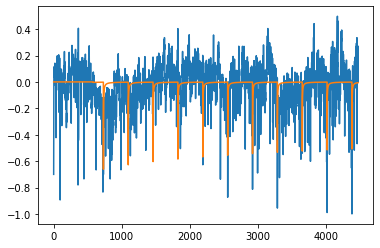

In [121]:
plt.plot(y_train)
plt.plot(y_predict)

In [122]:
y_predict = model.predict(X_test)

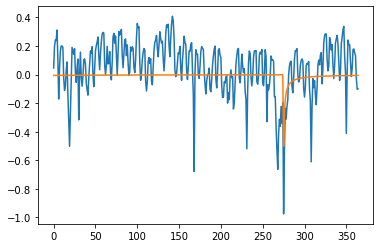

In [123]:
plt.plot(y_test)
plt.plot(y_predict)

In [124]:
ypred = model.predict(X_train)
yforc= model.predict(X_test)
y_new = np.hstack([ypred, yforc])

In [125]:
ynew1 = scaler1.inverse_transform(y_new.reshape(-1, 1))

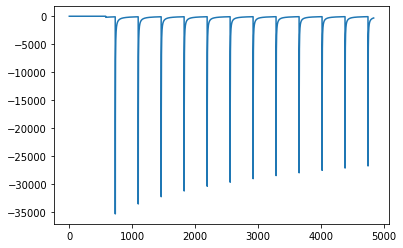

In [126]:
plt.plot(ynew1 + y_res.reshape(-1, 1))

In [127]:
newplot  = pd.concat([yi["predict"] + ynew1.reshape(-1), yi["real"]], axis = 1)

In [128]:
mp = mape_comp(newplot)
newplot[["real", "predict"]].iplot(title = f"MAPE: {mp:.2f}")

In [256]:
path_to_model = Path().resolve().parents[1] / "Models" / "GRegressor" / "GR_model_GR_Xtime_dayear_seasondiff-p1000-100it-mae.pkl"
with open(path_to_model, "wb") as f:
    pickle.dump(model, f)